# Final Project - Carrier Frequency Offset (CFO) Estimation

## Motivation

On Lab 08, we used the FFT of a known preamble to estimate the Carrier Frequency Offset (CFO) in our system. The frequency offset is a small difference between the receiver and transmitter carrier frequencies that introduces distortion to our system and decreases our detection ability.

The accuracy of our estimation depends on the length of the preamble and the length of the FFT we perform at the receiver. To increase accuracy, we could increase the length of the FFT to get more resolution across the entire spectrum. This method is computationally expensive, since we only care about the resolution of the FFT in a determined band (around the peak frequencies). In order to increase accuracy without sacrificing too much computation time, we can do a two step method.

First, we will take a coarse FFT (with a length of around 100). This will give us an estimate on where the peak frequency is located in our band. With this frequency, we perform a Zoom FFT in the surrounding frequncies. Using this we increase the accuracy, but only on the frequency set we are interested in.

In [2]:
# Import Libraries
import numpy as np
from scipy import signal
import pyfftw
import scipy.fftpack
import matplotlib.pyplot as plt
import pulse_shaping
import symbol_mod
import time
from scipy.signal import ZoomFFT

### Parameters

In [3]:
#Number of data bits
N = 10000
#Sampling frequency
fs = 1000000
Ts = 1/fs
#Samples per symbol
M = 8
# Length of FFT
full_L = 1000
# Length of zoom
comb_L = [100, 100]

### Creating the signal

We will use the preamble_generator below that was used in Lab 08 to generate the preamble. It will be a sequency of 200 bits. For the signal of interest, we create a random binary signal and add the preamble to the front of it. We use QPSK modulation and root raised cosine for the modulation. This gives us our signal of interest at baseband.

In [4]:
def preamble_generator(): 

        preamble = np.array([1,0,1,0])
        preamble = np.append(preamble, np.ones(6))                    
        preamble = np.append(preamble, np.zeros(10))   
        preamble = np.append(preamble, np.ones(180))
        
        return preamble

In [5]:
# Generate ideal baseband signal
def generate_baseband(N, fs, M):
    Bits = np.random.randint(0,2,N)  #random data
    x = np.random.choice([-1, 1], N)*np.sqrt(2)/2
    y = np.random.choice([-1, 1], N)*np.sqrt(2)/2
    preamble = preamble_generator()  
    payload_symbols = x + 1j*y
    #preamble = generateZC(200, 81)
    packet_bits = np.append(preamble, Bits)
    preamble_length = len(preamble)
    baseband_symbols = symbol_mod.symbol_mod(packet_bits, 'QPSK', preamble_length)
    #baseband_symbols = np.append(preamble, payload_symbols)
    pulse_shape = 'rrc'
    baseband = pulse_shaping.pulse_shaping(baseband_symbols, M, fs, pulse_shape, 0.9, 8)
    
    return baseband, preamble

In [6]:
baseband, preamble = generate_baseband(N, fs, M)

### Frequency offset generation

To simulate the effects of the channel, we treat the frequency_offset as a uniform random variable from -0.01 to 0.01 of the sampling frequency. We create the offset by multiplying our signal by a complex exponential.

In [7]:
def generate_baseband_offset(baseband, fs=fs):
    # Generate the frequency offset
    frequency_offset = np.random.uniform(-0.01*fs,0.01*fs)
    Ts = 1/fs
    t =  np.arange(0,len(baseband)*Ts,Ts)
    nonideal_term = np.exp(1j*2*np.pi*frequency_offset*t)
    baseband_with_frequency_offset = np.multiply(baseband,nonideal_term)
    
    return baseband_with_frequency_offset, frequency_offset

In [8]:
baseband_offset, offset = generate_baseband_offset(baseband, fs)
preamble_offset = baseband_offset[0:len(preamble)]

print("Frequency offset:", offset)

Frequency offset: 2197.7731028261387


# Frequency Estimation: Full FFT and Zoom FFT

#### Full FFT Method

In [9]:
def fft_baseband_offset(baseband, fs=fs, L=full_L):
    # FFT
    spectrum = np.abs(np.fft.fft(baseband, L))
    spectrum = np.fft.fftshift(spectrum)
    # Return max point
    peak = np.argmax(spectrum)
    offset = (peak - L/2)/L * fs
    
    return spectrum, offset

Calculated offset with full FFT: 2000.0 Hz


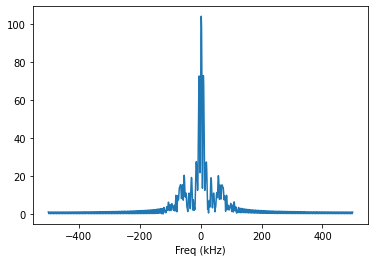

In [10]:
spectrum_offset_full, offset_full = fft_baseband_offset(preamble_offset, fs, full_L)

print("Calculated offset with full FFT:", offset_full, "Hz")
plt.plot(list(range(-500,500)), np.abs(spectrum_offset_full))
#plt.plot([0,0], [-2,110], '-r')
plt.xlabel("Freq (kHz)")
plt.show()

#### Combined Zoom FFT Method

The combined Zoom FFT Method uses both a full FFT and a Zoom FFT. After the full FFT identifies the peak point, the Zoom FFT does a FFT around that frequency. The range of frequencies for the Zoom FFT depends on the length of the full FFT. 

In [11]:
def zoomfft_baseband_offset(baseband, fs, M, L):
    transform = ZoomFFT(len(baseband), [-fs/(2*M), fs/(2*M)], L, fs=fs)
    spectrum = np.abs(transform(baseband))
    
    peak = np.argmax(spectrum)
    offset = (peak*fs) / ((L-1)*M) - fs/(2*M)
    
    return spectrum, offset

def zoomfft_baseband_offset_bounds(baseband, fs, bottom, top, L):
    transform = ZoomFFT(len(baseband), [bottom, top], L, fs=fs)
    spectrum = np.abs(transform(baseband))
    
    peak = np.argmax(spectrum)
    offset = (top - bottom)*peak/(L-1) + bottom
    
    return spectrum, offset

In [12]:
def combined_baseband_offset(baseband, fs, L):
    _, freq_est = fft_baseband_offset(baseband, fs, L[0])
    spectrum_offset_zoom, offset_zoom = zoomfft_baseband_offset_bounds(baseband, fs, freq_est-(0.5)*fs/L[0], freq_est+(0.5)*fs/L[0], L[1])

    return spectrum_offset_zoom, offset_zoom

Calculated offset with Zoom FFT: 2272.727272727273


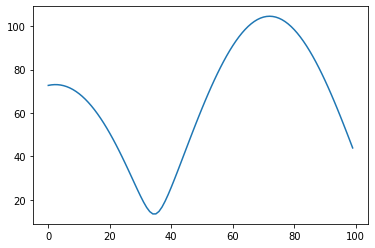

In [13]:
spectrum_offset_zoom, offset_zoom = combined_baseband_offset(preamble_offset, fs, comb_L)
    
print("Calculated offset with Zoom FFT:", offset_zoom)
plt.plot(np.abs(spectrum_offset_zoom))
plt.show()

### Quick Preamble Generation/Frequency Offset Calculations/Error Analysis (for testing purposes)

In [279]:
## FOR TESTING
baseband_offset, offset = generate_baseband_offset(baseband, fs)
preamble_offset = baseband_offset[0:len(preamble)]
spectrum_offset_zoom, offset_zoom = combined_baseband_offset(preamble_offset, fs, comb_L)
spectrum_offset_full, offset_full = fft_baseband_offset(preamble_offset, fs, full_L)
error_full = np.abs((offset - offset_full)*100/(offset))
error_zoom = np.abs((offset - offset_zoom)*100/(offset))

print("Frequency offset:", offset)
print("Error from full FFT estimation:", np.abs((offset - offset_full)), "or %f%%"%error_full)
print("Error from zoom FFT estimation:", np.abs((offset - offset_zoom)), "or %f%%"%error_zoom)

Frequency offset: 2996.202719881021
Error from full FFT estimation: 3.7972801189789607 or 0.126736%
Error from zoom FFT estimation: 84.60536092705934 or 2.823753%


### Error and Execution Time

In [237]:
error_full = np.abs((offset - offset_full)*100/(offset))
error_zoom = np.abs((offset - offset_zoom)*100/(offset))

print("Error from full FFT estimation:", np.abs((offset - offset_full)), "or %f%%"%error_full)
print("Error from zoom FFT estimation:", np.abs((offset - offset_zoom)), "or %f%%"%error_zoom)

Error from full FFT estimation: 485.0441747180048 or 7.445088%
Error from zoom FFT estimation: 20.397710071540132 or 0.313091%


In [280]:
error_full = 0
error_zoom = 0

time_full = 0
time_zoom = 0

comb_len = [500, 100]
full_len = 1000

num_full_better = 0

tests = 100 # Do not change this parameter


for i in range(tests):
    
    baseband, preamble = generate_baseband(N, fs, M)
    baseband_offset, offset = generate_baseband_offset(baseband, fs)
    preamble_offset = baseband_offset[0:200]
    
    # Full FFT
    start_time = time.time()
    spectrum_offset_full, offset_full = fft_baseband_offset(preamble_offset, fs, full_len)
    new_time_full = time.time() - start_time
    time_full += new_time_full
    
    # Zoom FFT
    start_time = time.time()
    spectrum_offset_zoom, offset_zoom = combined_baseband_offset(preamble_offset, fs, comb_len)
    new_time_zoom = time.time() - start_time
    time_zoom += new_time_zoom
    
    # Errors
    #new_error_full = np.abs((offset - offset_full)*100/(offset))
    new_error_full = np.abs(offset - offset_full)
    error_full += new_error_full
    #new_error_zoom = np.abs((offset - offset_zoom)*100/(offset))
    new_error_zoom = np.abs(offset - offset_zoom)
    error_zoom += new_error_zoom
    
    if(new_error_full < new_error_zoom):
        num_full_better +=1

error_full /= tests
time_full /= tests
error_zoom /= tests
time_zoom /= tests
    
print("Average error full FFT:", error_full, "Hz")
print("Average time full FFT: ", time_full*1000, "ms")
print("Average error zoom FFT:", error_zoom, "Hz")
print("Average time zoom FFT: ", time_zoom*1000, "ms")
print("\nNumber of time zoom FFT was less accurate:", num_full_better)

#store_data([full_len, comb_len[0], comb_len[1], error_full, time_full, error_zoom, time_zoom])

Average error full FFT: 256.4581098778942 Hz
Average time full FFT:  0.1607227325439453 ms
Average error zoom FFT: 11.128614052590216 Hz
Average time zoom FFT:  0.3292989730834961 ms

Number of time zoom FFT was less accurate: 1


### Appendix

### Storing data for Error and Execution Time

In [9]:
def store_data(data):
    with open("data.mem", "a") as file:
        data_text = " ".join([str(i) for i in data]) + "\n"
        file.write(data_text)
        
def read_data():
    with open("data.mem", "r") as file:
        data = file.readline()

### Characterizing full FFT

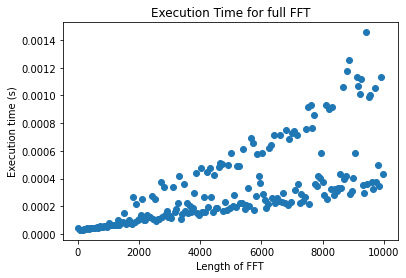

In [32]:
full_len = 10
tests = 1000
timing = []
lengths = []

while (full_len < 10000):
    time_full = 0
    for i in range(tests):
        # Full FFT
        start_time = time.time()
        spectrum_offset_full, offset_full = fft_baseband_offset(preamble_offset, fs, full_len)
        new_time_full = time.time() - start_time
        time_full += new_time_full

    time_full /= tests
    
    timing.append(time_full)
    lengths.append(full_len)
    full_len += 50

plt.scatter(lengths, timing)
plt.title("Execution Time for full FFT")
plt.xlabel("Length of FFT")
plt.ylabel("Execution time (s)")
plt.show()

### Characterizing combined Zoom + Full FFT

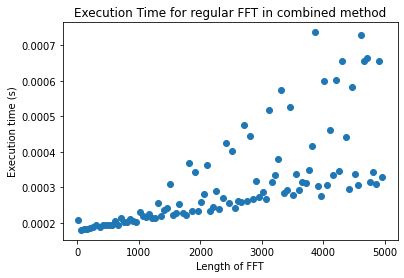

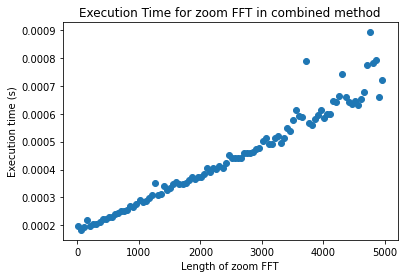

In [33]:
comb_len = [10, 10]
tests = 1000
timing = []
lengths_zoom = []
lengths_full = []

while (comb_len[0] < 5000 and comb_len[1] < 5000):
    time_zoom = 0
    for i in range(tests):
        # Zoom FFT
        start_time = time.time()
        spectrum_offset_zoom, offset_zoom = combined_baseband_offset(preamble_offset, fs, comb_len)
        new_time_zoom = time.time() - start_time
        time_zoom += new_time_zoom

    time_zoom /= tests
    
    timing.append(time_zoom)
    lengths_full.append(comb_len[0])
    comb_len[0] += 50

plt.scatter(lengths_full, timing)
plt.title("Execution Time for regular FFT in combined method")
plt.xlabel("Length of FFT")
plt.ylabel("Execution time (s)")
plt.show()
    
timing = []
comb_len = [10, 10]
while (comb_len[0] < 5000 and comb_len[1] < 5000):
    time_zoom = 0
    for i in range(tests):
        # Zoom FFT
        start_time = time.time()
        spectrum_offset_zoom, offset_zoom = combined_baseband_offset(preamble_offset, fs, comb_len)
        new_time_zoom = time.time() - start_time
        time_zoom += new_time_zoom

    time_zoom /= tests
    
    lengths_zoom.append(comb_len[1])
    timing.append(time_zoom)
    comb_len[1] += 50
    
plt.scatter(lengths_zoom, timing)
plt.title("Execution Time for zoom FFT in combined method")
plt.xlabel("Length of zoom FFT")
plt.ylabel("Execution time (s)")
plt.show()

## Carrier Phase Offset Estimation

In Lab 08 we used a OOK preamble signal in order to estimate the phase offset in the channel. For this section of our Final Project, we moved the Carrier Phase Offset estimation to work for QPSK preambles.

### General framework for phase detection

The code below shows a generic example of how we can calculate the CPO for a QPSK preamble. The difference between the two methods lies in the computational efficiency of the approach. For Method #1, we need to take two arctan operations (computationally expensive), while Method #2 only requires simpler arithmetic computations.

In [384]:
# Generate random QPSK symbol
x = np.random.choice([-1, 1])*np.sqrt(2)/2
y = np.random.choice([-1, 1])*np.sqrt(2)/2
s = x + 1j*y

# Generate random phase offset
phase_offset = np.random.uniform(-np.pi, np.pi)
print("Phase offset (degrees):", phase_offset*180/np.pi)

# Add phase offset
s_offset = s*np.exp(1j*phase_offset)

# First method for error estimation
e_k = np.angle(s_offset) - np.arctan(np.sign(np.imag(s_offset))/np.sign(np.real(s_offset)))
print("Phase estimation #1:", e_k*180/np.pi)

# Second method for error estimation
e_k = (np.imag(s_offset)*np.sign(np.real(s_offset)) - np.real(s_offset)*np.sign(np.imag(s_offset)))*np.sqrt(2)/2
print("Phase estimation #2:", np.angle(1j*e_k + np.sqrt(1 - e_k**2))*180/np.pi)

# Correct for phase offset
s_corrected = s_offset*(1j*e_k + np.sqrt(1 - e_k**2))

Phase offset (degrees): -151.87077465102058
Phase estimation #1: -151.87077465102058
Phase estimation #2: 28.12922534897942


### Ambiguity and CPO

For QPSK, our phase offset detector has a pi/2 ambiguity. This means that when we correct our signal we might get a rotated version of our original symbols by 0, 90, 180 or 270 degrees. To compensate for the rotation, we can send a known preamble in order to figure out the rotation and compensate for it.

In [22]:
def cpo_estimation(preamble, known_preamble):
    
    e_k = (np.imag(preamble)*np.sign(np.real(preamble)) - np.real(preamble)*np.sign(np.imag(preamble)))*np.sqrt(2)/2
    
    e_k = np.arcsin(e_k)
    
    return np.mean(e_k)

def cpo_rotation_angle(preamble, known_preamble):
    
    e_k = cpo_estimation(preamble, known_preamble)
    
    preamble_corrected = preamble*np.exp(-1j*e_k)
    
    angle_rotation = np.mean(np.angle(preamble_corrected) - np.angle(known_preamble))
    
    return angle_rotation + e_k
  
def cpo_rotate(sequence, preamble_length, known_preamble):
    
    angle = cpo_rotation_angle(sequence[0:preamble_length], known_preamble)
    
    sequence_corrected = sequence*np.exp(-1j*angle)
    
    return sequence_corrected

This code below does some testing on a randomly generated QPSK signal with a known preamble. It then confirms that we were able to get the signal back with the phase and ambiguity corrected.

In [430]:
N = 10
x = np.random.choice([-1, 1], N)*np.sqrt(2)/2
y = np.random.choice([-1, 1], N)*np.sqrt(2)/2
s = x + 1j*y
preamble = [np.sqrt(2)/2 + 1j*np.sqrt(2)/2]
packet = np.append(preamble, s)
phase_offset = np.random.uniform(-np.pi, np.pi)
packet_offset = packet*np.exp(1j*phase_offset)
preamble_offset = packet_offset[0]

print("Phase offset:", np.remainder(phase_offset*180/np.pi, 360))
print("Phase offset estimation:", np.remainder(cpo_rotation_angle(preamble_offset, preamble)*180/np.pi, 360))
print("Equality test after phase correction:", np.isclose(cpo_rotate(packet_offset, 1, preamble), packet, 0.0001).all())

Phase offset: 189.67907533701904
Phase offset estimation: 189.67907533701904
Equality test after phase correction: True


## Preamble and Timing Offset: Zadoff-Chu Sequence

### Generating the Zadoff-Chu sequence

In [15]:
# N: Length of ZC sequence
# u: Less than N, coprime with N
def generateZC(N, u):
    n = np.linspace(0, N-1, N)

    ZC = np.exp(-1j*np.pi*(n+1)*n*u/N)
    
    return ZC

#### Zadoff-Chu properties

As we can see below, ZC sequencues exhibit some interesting correlation properties. The auto correlation of a Zadoff–Chu sequence with a cyclically shifted version of itself is zero, i.e., it is non-zero only at one instant which corresponds to the cyclic shift. This property is useful for frame detection.

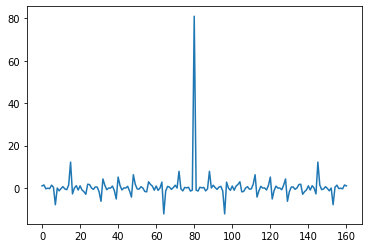

In [16]:
ZC = generateZC(81, 10)
    
X = np.correlate(ZC, ZC, mode="full")

plt.plot(np.real(X))
plt.show()

### Comparing the ZC sequence with the regular OOK preamble

In Lab 07 we studied frame detection using a OOK preamble. We want to compare the performance of the OOK preamble frame detection and QPSK frame detection compared to the ZC preamble detection.

#### OOK Frame Detection

In [17]:
def frame_sync(data_bb_ac, known_preamble_ac):
        
        matched_filter_coef = np.flip(known_preamble_ac, 0)
        crosscorr = signal.fftconvolve(data_bb_ac, matched_filter_coef)

        return crosscorr

count = 0 # This counts the amount of errors

for i in range(10000):
    #preamble = np.random.choice([-1, 1], 10)*np.sqrt(2)/2
    preamble = np.random.randint(0, 2, 10)

    #payload = np.random.choice([-1, 1], 128)*np.sqrt(2)/2
    payload = np.random.randint(0, 2, 128) 
    start_index = np.random.randint(0, 128)

    final_payload = np.insert(payload, start_index, preamble)

    crosscorr = frame_sync(final_payload, preamble)

    peak = np.argmax(crosscorr) - len(preamble) + 1
    
    if (peak != start_index):
        count += 1

print("Percentage of tests with frame start mismatch in OOK: {}%".format(count*100/10000))

Percentage of tests with frame start mismatch in OOK: 65.01%


#### QPSK Frame Detection

In [18]:
def frame_sync(data_bb_ac, known_preamble_ac):
        
        matched_filter_coef = np.flip(known_preamble_ac, 0)
        crosscorr = signal.fftconvolve(data_bb_ac, matched_filter_coef)

        return crosscorr
 
count = 0 # This counts the amount of errors

for i in range(10000):
    preamble = np.random.choice([-1, 1], 10)*np.sqrt(2)/2
    
    payload = np.random.choice([-1, 1], 128)*np.sqrt(2)/2

    start_index = np.random.randint(0, 128)

    final_payload = np.insert(payload, start_index, preamble)

    crosscorr = frame_sync(final_payload, preamble)

    peak = np.argmax(crosscorr) - len(preamble) + 1 
    
    if (peak != start_index):
        count += 1

print("Percentage of tests with frame start mismatch in QPSK: {}%".format(count*100/10000))

Percentage of tests with frame start mismatch in QPSK: 5.94%


In [19]:
def frame_sync(data_bb_ac, known_preamble_ac):
        
        crosscorr = np.correlate(data_bb_ac, known_preamble_ac, mode="full")
        
        return crosscorr

count = 0

frequency_offset = np.random.uniform(-0.01*fs,0.01*fs)
Ts = 1/fs
t =  np.arange(0,len(baseband)*Ts,41593)
nonideal_term = np.exp(1j*2*np.pi*frequency_offset*t)

for i in range(10000):    
    N = 10
    u = 7

    n = np.linspace(0, N-1, N)

    preamble = np.exp(-1j*np.pi*(n+1)*n*u/N)

    payload = np.random.choice([-1, 1], 128)*np.sqrt(2)/2

    start_index = np.random.randint(0, 128)

    final_payload = np.multiply(np.insert(payload, start_index, preamble), nonideal_term)

    crosscorr = frame_sync(final_payload, preamble)

    peak = np.argmax(np.real(crosscorr)) - len(preamble) + 1 

    if (peak != start_index):
        count += 1
        
print("Percentage of tests with frame start mismatch in ZC: {}%".format(count*100/10000))

/home/dgarci23/.local/lib/python3.8/site-packages/numpy/lib/function_base.py:5287: ComplexWarning: Casting complex values to real discards the imaginary part
  values = array(values, copy=False, ndmin=arr.ndim, dtype=arr.dtype)


Percentage of tests with frame start mismatch in ZC: 0.0%


## Combining Zadoff-Chu and Previous Preamble

In [20]:
#Number of data bits
N = 10000
#Zadoff-Chu parameters
N_zc = 81
u = 10
#Length of zoom
comb_len = [500, 100]


#generating initial signals
preamble_ZC = generateZC(N_zc,u)
preamble_freq_est = preamble_generator()
preamble = np.append(preamble_ZC, preamble_freq_est)
Bits = np.random.randint(0,2,N)  #random data

packet_bits = np.append(preamble, Bits)
preamble_length = [len(preamble_ZC), len(preamble_freq_est)]
baseband_symbols = symbol_mod.symbol_mod(packet_bits, 'QPSK', np.sum(preamble_length))
pulse_shape = 'rrc'
baseband = pulse_shaping.pulse_shaping(baseband_symbols, M, fs, pulse_shape, 0.9, 8)

payload = np.random.choice([-1, 1], 50*N)*np.sqrt(2)/2

start_index = np.random.randint(0, 50*N)

final_payload, frequency_offset = generate_baseband_offset(np.insert(payload, start_index, preamble), fs)


#Processing Signal
#Peak Detection
crosscorr = frame_sync(final_payload, preamble_ZC)
peak = np.argmax(np.real(crosscorr)) - len(preamble_ZC) + 1

signal = final_payload[peak+preamble_length[0] : peak+len(baseband_symbols)-preamble_length[0]]


#Frequency Correction
preamble_offset = signal[0:preamble_length[1]]


# Zoom FFT
spectrum_offset_zoom, offset_zoom = combined_baseband_offset(preamble_offset, fs, comb_len)
print("Zoom FFT estimate after dual preamble:\t", offset_zoom)



################################################################################################################
#DIRECTLY RECOMPUTING WHAT THE PREAMBLE SHOULD BE AND RECALCULATING FFT
t =  np.arange(0,(51*N+281)*Ts,Ts)
nonideal_term = np.exp(1j*2*np.pi*frequency_offset*t[start_index+N_zc:(start_index+N_zc+len(preamble_freq_est))])
preamble_offset_direct = np.multiply(preamble_freq_est,nonideal_term)


spectrum_offset_zoom, offset_zoom = combined_baseband_offset(np.multiply(preamble_freq_est,nonideal_term), fs, comb_len)
################################################################################################################


#error_zoom = np.abs((frequency_offset - offset_zoom)*100/(offset))

print("Frequency offset: \t\t\t", frequency_offset)
print("Zoom FFT estimate direct:\t\t", offset_zoom)
#print("Error from zoom FFT estimation:", np.abs((frequency_offset - offset_zoom)), "or %f%%"%error_zoom)

ValueError: too many values to unpack (expected 2)

In [ ]:
def generate_baseband_offset(baseband, fs=fs):
    # Generate the frequency offset
    frequency_offset = np.random.uniform(-0.01*fs,0.01*fs)
    phase_offset = np.random.uniform(-np.pi, np.pi)
    Ts = 1/fs
    t =  np.arange(0,len(baseband)*Ts,Ts)
    nonideal_term = np.exp(1j*(2*np.pi*frequency_offset*t + phase_offset))
    baseband_with_frequency_offset = np.multiply(baseband,nonideal_term)
    
    return baseband_with_frequency_offset, frequency_offset, phase_offset

def frame_sync(data_bb_ac, known_preamble_ac):
        
        crosscorr = np.correlate(data_bb_ac, known_preamble_ac, mode="full")
        
        return crosscorr

count_frame = 0
count_phase = 0
count_freq = 0
    
for i in range(10000):
    ZC = generateZC(36, 1)

    preamble = ZC
    payload = (np.random.choice([1, -1], 300) + 1j*np.random.choice([1, -1], 300))*np.sqrt(2)/2
    config = np.array(20*[1 + 1j])/np.sqrt(2)

    start_index = np.random.randint(0, 128)

    packet = np.insert(payload, start_index, preamble)

    packet = np.append(config, packet)

    packet_mod = pulse_shaping.pulse_shaping(packet, M, fs, "rect", None, None)

    packet_mod_offset, freq_offset, phase_offset = generate_baseband_offset(packet_mod, fs=fs)

    packet_zoom, freq_offset_est = combined_baseband_offset(packet_mod_offset[0:10], fs, [500, 500])

    Ts = 1/fs
    t = np.arange(0,len(packet_mod)*Ts,Ts)
    Digital_LO = np.exp(1j*(-2*np.pi*freq_offset_est*t))

    packet_freq_corrected = np.multiply(packet_mod_offset,Digital_LO)

    phase_offset_est = cpo_rotation_angle(packet_freq_corrected[0:10], config[0:10])

    packet_corrected = packet_freq_corrected*np.exp(-1j*phase_offset_est)

    packet_demod = packet_corrected[::M]

    crosscorr = frame_sync(packet_demod, ZC)

    peak = np.argmax(np.real(crosscorr)) - len(ZC) + 1 - len(config)

    if (not(np.isclose(phase_offset,phase_offset_est,0.050))):
        count_phase += 1
        
    if not(np.isclose(freq_offset,freq_offset_est,50)):
        count_freq += 1
        
    if (peak!=start_index):
        count_frame += 1
        
print("Frame start errors:", count_frame)
print("Frequency offset estimation errors:", count_freq)
print("Phase offset estimation errors:", count_phase)